In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [ ]:
#dataset on Google Drive
train_data_path = "/content/drive/MyDrive/CIS_581_FINAL/Celebs_2"

#data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

#instance of the ImageFolder dataset
train_dataset = ImageFolder(root=train_data_path, transform=transform)
batch_size = 32
shuffle = True
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle, num_workers=4)

In [ ]:
# Check if a GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ImprovedFaceRecognitionModel(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedFaceRecognitionModel, self).__init__()
        resnet = models.resnet50(pretrained=True)

        #Remove the fully connected layer
        self.features = nn.Sequential(*list(resnet.children())[:-2])

        # new layers for tuning - will be num_classes=4 CLASSES, for Shaq/Ryan/Steve/Control
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(resnet.fc.in_features, num_classes)

        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

In [1]:
# Create an instance of the FaceRecognitionModel
num_classes = 4  # A, B, C, Control
#model = FaceRecognitionModel(num_classes)
model = ImprovedFaceRecognitionModel(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00018)

#train
num_epochs = 12  # Adjust as needed
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()}")

In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/CIS_581_FINAL/trained_model_gpu_C4_2.pth')

In [ ]:
model_path = '/content/drive/MyDrive/CIS_581_FINAL/trained_model_gpu_C4_2.pth'

#model architecture
num_classes = 4
model = ImprovedFaceRecognitionModel(num_classes)
model.load_state_dict(torch.load(model_path))
model.eval()

ImprovedFaceRecognitionModel(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
    

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

def preprocess_test_image(test_image_path):
    # Define data transformations
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Open the image and apply transformations
    test_image = Image.open(test_image_path)
    if test_image.mode != 'RGB':
        test_image = test_image.convert('RGB')

    #apply transformations, normalize
    test_image = test_transform(test_image)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    test_image = transforms.functional.normalize(test_image, mean, std)
    test_image = test_image.unsqueeze(0)

    return test_image


# Specify the path to your test image
test_image_path_steve = '/content/drive/MyDrive/CIS_581_FINAL/steve_test.png'
test_image_path_shaq = '/content/drive/MyDrive/CIS_581_FINAL/shaq_test.png'
test_image_path_ryan = '/content/drive/MyDrive/CIS_581_FINAL/ryan_test.png'
test_image_path_ryan_2 = '/content/drive/MyDrive/CIS_581_FINAL/ryan_test_2.jpg'
test_image_path_kacy = '/content/drive/MyDrive/CIS_581_FINAL/kacy_test.jpg'
test_image_path_hugh = '/content/drive/MyDrive/CIS_581_FINAL/hugh_test.jpg'
test_image_path_forest = '/content/drive/MyDrive/CIS_581_FINAL/forest_test.jpg'
test_image_path_jacob = '/content/drive/MyDrive/CIS_581_FINAL/jacob_test.jpg'
test_image_path_gosling = '/content/drive/MyDrive/CIS_581_FINAL/gosling_test.jpg'
test_image_path_bean = '/content/drive/MyDrive/CIS_581_FINAL/mr_bean_test.jpg'



test_image_steve = preprocess_test_image(test_image_path_steve)
test_image_shaq = preprocess_test_image(test_image_path_shaq)
test_image_ryan = preprocess_test_image(test_image_path_ryan)
test_image_ryan_2 = preprocess_test_image(test_image_path_ryan_2)
test_image_kacy = preprocess_test_image(test_image_path_kacy)
test_image_hugh = preprocess_test_image(test_image_path_hugh)
test_image_forest = preprocess_test_image(test_image_path_forest)
test_image_jacob = preprocess_test_image(test_image_path_jacob)
test_image_gosling = preprocess_test_image(test_image_path_gosling)
test_image_bean = preprocess_test_image(test_image_path_bean)



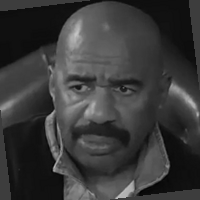

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 3, Confidence: 0.9999477863311768
The model predicts that the image belongs to steve.


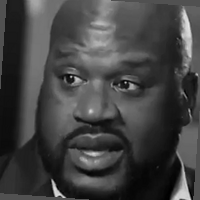

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 2, Confidence: 0.9989234805107117
The model predicts that the image belongs to shaq.


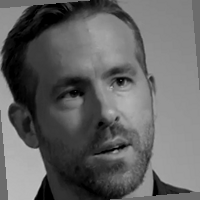

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 1, Confidence: 0.988867461681366
The model predicts that the image belongs to ryan.


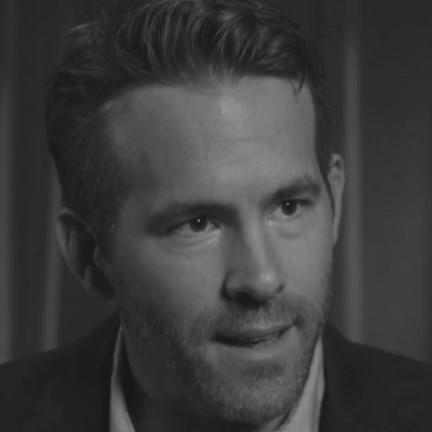

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 3, Confidence: 0.40350499749183655
The model predicts that the image belongs to steve.


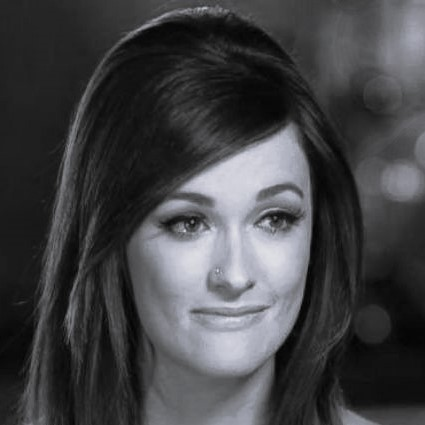

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 0, Confidence: 0.8992010354995728
The model predicts that the image belongs to control.


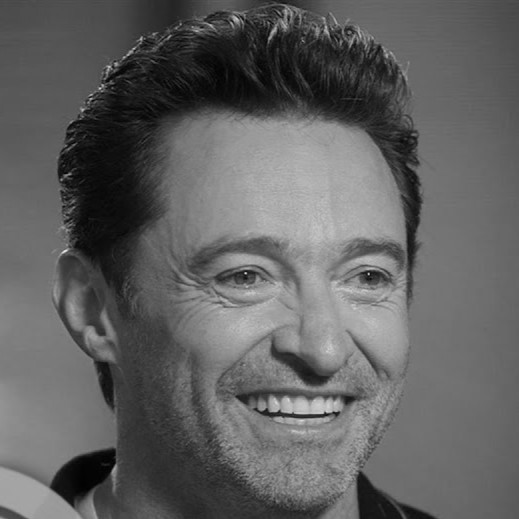

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 0, Confidence: 0.5323047637939453
The model predicts that the image belongs to control.


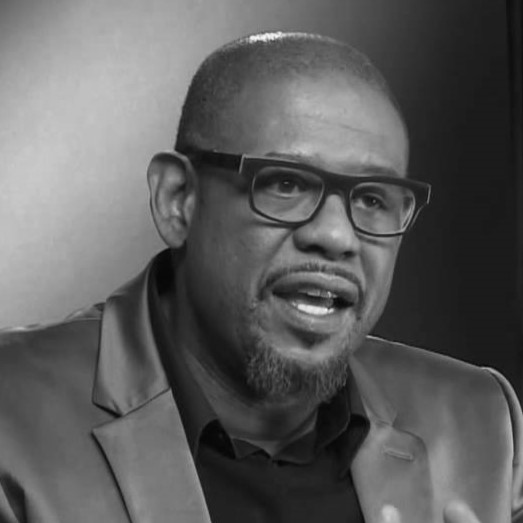

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 0, Confidence: 0.7653086185455322
The model predicts that the image belongs to control.


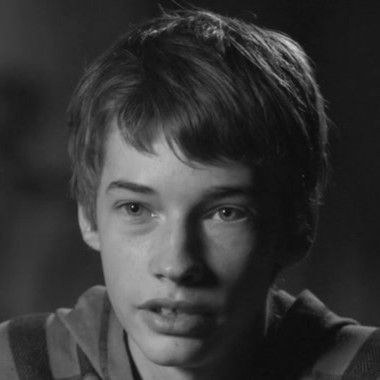

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 0, Confidence: 0.8819788098335266
The model predicts that the image belongs to control.


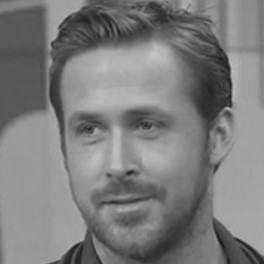

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 0, Confidence: 0.768836498260498
The model predicts that the image belongs to control.


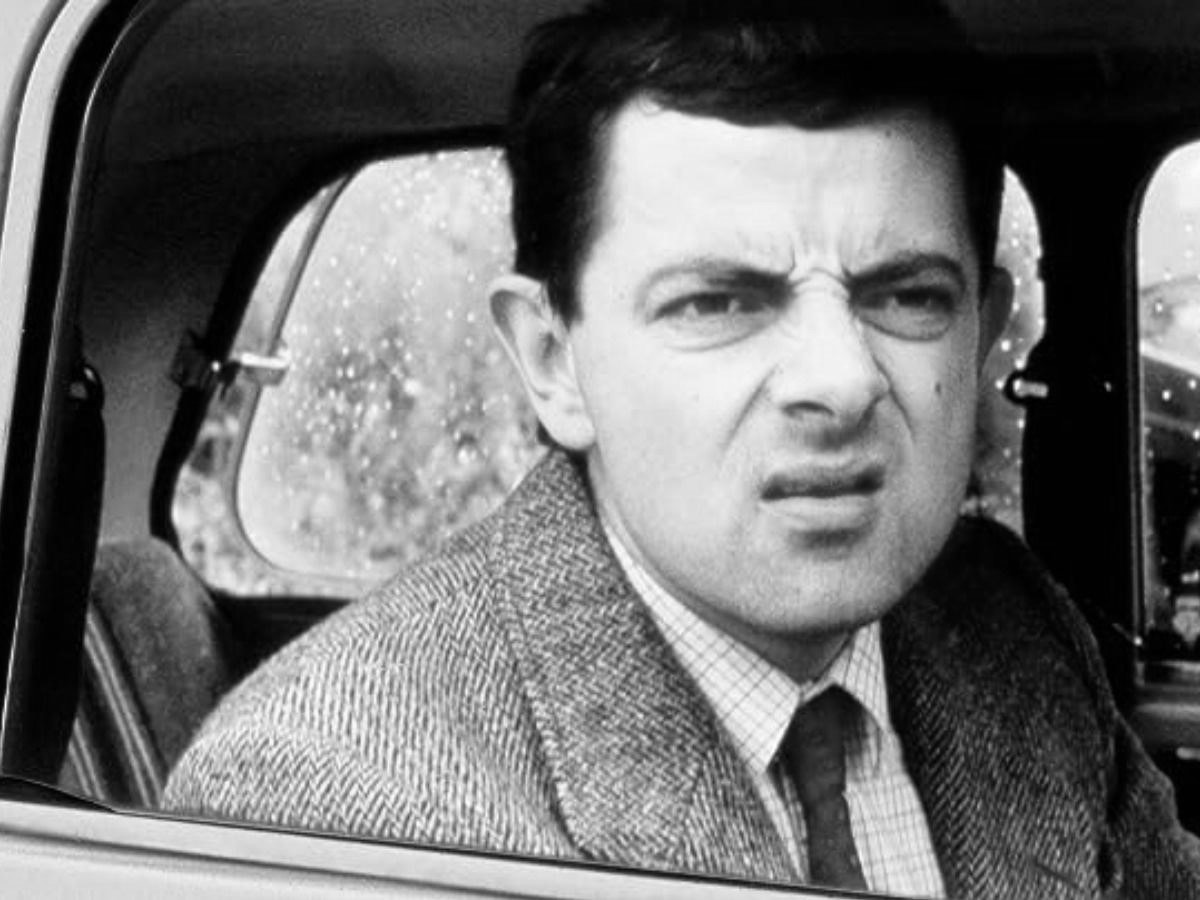

Class labels: ['control', 'ryan', 'shaq', 'steve']
Predicted Class: 0, Confidence: 0.9986727237701416
The model predicts that the image belongs to control.


In [ ]:
# Forward pass through the model
from IPython.display import Image, display

def predict_test_image(test_image_path, test_image):

  display(Image(filename=test_image_path))

  with torch.no_grad():
      outputs = model(test_image)
  # Get the predicted class
  _, predicted_class = torch.max(outputs, 1)
  print("Class labels:", train_dataset.classes)
  confidence = torch.nn.functional.softmax(outputs, dim=1)[0][predicted_class].item()

  print(f"Predicted Class: {predicted_class.item()}, Confidence: {confidence}")

  #map predicted class to the corresponding person (A, B, C, control)
  persons = ['control', 'ryan', 'shaq', 'steve']
  predicted_person = persons[predicted_class.item()]

  print(f"The model predicts that the image belongs to {predicted_person}.")

predict_test_image(test_image_path_steve, test_image_steve)
predict_test_image(test_image_path_shaq, test_image_shaq)
predict_test_image(test_image_path_ryan, test_image_ryan)
predict_test_image(test_image_path_ryan_2, test_image_ryan_2)
predict_test_image(test_image_path_kacy, test_image_kacy)
predict_test_image(test_image_path_hugh, test_image_hugh)
predict_test_image(test_image_path_forest, test_image_forest)
predict_test_image(test_image_path_jacob, test_image_jacob)
predict_test_image(test_image_path_gosling, test_image_gosling)
predict_test_image(test_image_path_bean, test_image_bean)